# Table of Contents
- [Major Classes and File Parsing](#Major-Classes-and-File-Parsing)
- [Load the Data](#Load-the-Data)
- [Feature Extraction](#Feature-Extraction)
- [Feature Selection](#Feature-Selection)
 - [Pandas-based Feature Exploration](#Pandas-based-Feature-Exploration)
 - [Cross Correlation](#Cross-Correlation)
 - [Variance Threshold](#Variance-Threshold)
 - [Univariate Feature Selection](#Univariate-Feature-Selection)
 - [Recursive Feature Elimination](#Recursive-Feature-Elimination)
- [Parameter Tuning](#Parameter-Tuning)
- [Evaluation Approaches](#Evaluation-Approaches)

In [1]:
# This cell includes the major classes used in our classification analyses
import matplotlib.pyplot as plt # needed for plotting
import numpy as np # numpy is primary library for numeric array (and matrix) handling
import scipy as sp
from scipy import stats, signal
import random
from sklearn import svm # needed for svm
from sklearn.metrics import confusion_matrix
import itertools
import pandas as pd

# Each accelerometer log file gets parsed and made into a SensorData object
class SensorData:
    
    # Constructors in Python look like this (strangely enough)
    # All arguments are numpy arrays except sensorType, which is a str
    def __init__(self, sensorType, currentTimeMs, sensorTimestampMs, x, y, z):
        self.sensorType = sensorType
        
        # On my mac, I could cast as straight-up int but on Windows, this failed
        # This is because on Windows, a long is 32 bit but on Unix, a long is 64bit
        # So, forcing to int64 to be safe. See: https://stackoverflow.com/q/38314118
        self.currentTimeMs = currentTimeMs.astype(np.int64)
        
        # sensorTimestampMs comes from the Arduino function 
        # https://www.arduino.cc/reference/en/language/functions/time/millis/
        # which returns the number of milliseconds passed since the Arduino board began running the current program.
        self.sensorTimestampMs = sensorTimestampMs.astype(np.int64)
        
        self.x = x.astype(float)
        self.y = y.astype(float)
        self.z = z.astype(float)
   
        # Calculate the magnitude of the signal
        self.mag = np.sqrt(self.x**2 + self.y**2 + self.z**2)
        
        self.sampleLengthInSecs = (self.currentTimeMs[-1] - self.currentTimeMs[0]) / 1000.0
        self.samplesPerSecond = len(self.currentTimeMs) / self.sampleLengthInSecs 
        
    def __str__(self):
        return "'{}' : Length={} samples ({}s) SamplingRate={: 0.1f}Hz".format(
            self.sensorType, len(self.x), self.sampleLengthInSecs, self.samplesPerSecond)
        
    # Returns a dict of numpy arrays for each axis of the accel + magnitude
    def get_data(self):
        return {"x":self.x, "y":self.y, "z":self.z, "mag":self.mag}
    
    # Returns a dict of numpy arrays for each axis of the accel + magnitude
    def get_processed_data(self):
        return {"x_p":self.x_p, "y_p":self.y_p, "z_p":self.z_p, "mag_p":self.mag_p}

# A trial is one gesture recording and includes an accel SensorData object
# In the future, this could be expanded to include other recorded sensors (e.g., a gyro)
# that may be recorded simultaneously
class Trial:
    
    # We actually parse the sensor log files in the constructor--this is probably bad practice
    # But offers a relatively clean solution
    def __init__(self, gestureName, endTimeMs, trialNum, accelLogFilenameWithPath):
        self.gestureName = gestureName
        self.trialNum = trialNum
        self.endTimeMs = endTimeMs
        self.accelLogFilenameWithPath = accelLogFilenameWithPath
        self.accelLogFilename = os.path.basename(accelLogFilenameWithPath)
        
        # unpack=True puts each column in its own array, see https://stackoverflow.com/a/20245874
        # I had to force all types to strings because auto-type inferencing failed
        parsedAccelLogData = np.genfromtxt(accelLogFilenameWithPath, delimiter=',', 
                              dtype=str, encoding=None, skip_header=1, unpack=True)
        
        # The asterisk is really cool in Python. It allows us to "unpack" this variable
        # into arguments needed for the SensorData constructor. Google for "tuple unpacking"
        self.accel = SensorData("Accelerometer", *parsedAccelLogData)
    
    # start timestamp
    def get_start_time(self):
        return self.accel.currentTimeMs[0]
    
    # end timestamp
    def get_end_time(self):
        return self.accel.currentTimeMs[-1]
    
    # Utility function that returns the end time as a nice string
    def getEndTimeMsAsString(self):
        return time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(self.endTimeMs / 1000))
    
    def __str__(self):
         return "'{}' : Trial {} from {}".format(self.gestureName, self.trialNum, self.accelLogFilename)

# Container for a single set of gestures and trials
class GestureSet:
    CORE_GESTURE_NAMES = set(['Pulling', "Dont pay Attention", 'Flip', 
                          'Clap', "Elephant Arm"])
    
    def __init__(self, gesture_log_path, map_gestures_to_trials, full_sensor_stream):
        self.path = gesture_log_path
        self.map_gestures_to_trials = map_gestures_to_trials
        self.full_sensor_stream = full_sensor_stream
    
    # Returns all trials sorted by start timestamp
    def get_all_trials(self):
        trials = list()
        for gesture_name, trial_list in self.map_gestures_to_trials.items():
            trials += trial_list
            
        trials.sort(key=lambda x: x.get_start_time())
        return trials
    
    # Returns all trials for this gesture sorted by start timestamp
    def get_trials(self, gesture_name):
        #print(type(self.map_gestures_to_trials))
        return self.map_gestures_to_trials[gesture_name]

    # returns trials for a gesture name
    def get_trials_for_gesture(self, gesture_name):
        return self.map_gestures_to_trials[gesture_name]
    
    # returns the longest trial (based on num rows recorded and not clock time)
    def get_longest_trial(self):
        longest_trial_length = -1
        longest_trial = None
        for gesture_name, trial_list in self.map_gestures_to_trials.items():
            for trial in trial_list:
                if longest_trial_length < len(trial.accel.x):
                    longest_trial_length = len(trial.accel.x)
                    longest_trial = trial
        return longest_trial
    
    def get_name(self):
        return self.get_base_path()
    
    # returns the base path
    def get_base_path(self):
        return os.path.basename(os.path.normpath(self.path))
    
    # returns the number of gestures
    def get_num_gestures(self):
        return len(self.map_gestures_to_trials)
    
    # creates an aggregate signal based on *all* trials for this gesture
    # TODO: in future could add in an argument, which takes a list of trial nums
    # to use to produce aggregate signal
    def create_aggregate_signal(self, gesture_name, signal_var_name):
        trials = self.get_trials_for_gesture(gesture_name)
        aggregate_signal = None
        trial_signals = []
        trial_signals_original = []
        first_trial = None
        first_trial_signal = None
        
        max_length = -1
        for trial in trials:
            trial_signal = getattr(trial.accel, signal_var_name)
            if max_length < len(trial_signal):
                max_length = len(trial_signal)
            
        for i in range(len(trials)):
            if i == 0:
                first_trial = trials[i]
                trial_signal = getattr(first_trial.accel, signal_var_name)
                trial_signal_mod = np.copy(trial_signal)

                trial_signals.append(trial_signal_mod)
                trial_signals_original.append(trial_signal)
                
                array_length_diff = max_length - len(trial_signal_mod)
                trial_signal_mod = np.pad(trial_signal_mod, (0, array_length_diff), 'mean')  

                aggregate_signal = trial_signal_mod
                first_trial_signal = trial_signal_mod
            else:
                cur_trial = trials[i]
                cur_trial_signal = getattr(trial.accel, signal_var_name) 
                trial_signals_original.append(cur_trial_signal)
                
                array_length_diff = max_length - len(cur_trial_signal)
                cur_trial_signal_mod = np.pad(cur_trial_signal, (0, array_length_diff), 'mean') 

                cur_trial_signal_mod = get_aligned_signal_cutoff_and_pad(cur_trial_signal_mod, first_trial_signal)
                trial_signals.append(cur_trial_signal_mod)
                aggregate_signal += cur_trial_signal_mod
        
        mean_signal = aggregate_signal / len(trial_signals) 
        return mean_signal

    # Returns the minimum number of trials across all gestures (just in case we accidentally recorded a 
    # different number. We should have the same number of trials across all gestures)
    def get_min_num_of_trials(self):
        minNumTrials = -1 
        for gestureName, trialSet in self.map_gestures_to_trials.items():
            if minNumTrials == -1 or minNumTrials > len(trialSet):
                minNumTrials = len(trialSet)
        return minNumTrials

    # returns the total number of trials
    def get_total_num_of_trials(self):
        numTrials = 0 
        for gestureName, trialSet in self.map_gestures_to_trials.items():
            numTrials = numTrials + len(trialSet)
        return numTrials
    
    # get random gesture name
    def get_random_gesture_name(self):
        gesture_names = list(self.map_gestures_to_trials.keys())
        rand_gesture_name = gesture_names[random.randint(0, len(gesture_names) - 1)]
        return rand_gesture_name
    
    # get random trial
    def get_random_trial(self):
        rand_gesture_name = self.get_random_gesture_name()
        print("rand_gesture_name", rand_gesture_name)
        trials_for_gesture = self.map_gestures_to_trials[rand_gesture_name]
        return trials_for_gesture[random.randint(0, len(trials_for_gesture) - 1)]
    
    # convenience method (duplicates get_gesture_names_sorted)
    def get_gesture_names(self):
        return self.get_gesture_names_sorted()
    
    # returns a sorted list of gesture names
    def get_gesture_names_sorted(self, filter_custom_gesture=False):
        if filter_custom_gesture == False:
            return sorted(self.map_gestures_to_trials.keys())
        else:
            filtered_names = []
            for gesture_name in self.map_gestures_to_trials.keys():
                if gesture_name in self.CORE_GESTURE_NAMES:
                    filtered_names.append(gesture_name)
            return filtered_names
    
    # returns the custom gesture name
    def get_custom_gesture_name(self):
        set_all_gesture_names = set(self.map_gestures_to_trials.keys())
        set_filter_names = set(self.get_gesture_names_sorted(filter_custom_gesture=True))
        set_diff = set_all_gesture_names - set_filter_names
        if len(set_diff) > 0:
            return set_diff.pop()
        return None
         
    # prettify the str()
    def __str__(self):
         return "'{}' : {} gestures and {} total trials".format(self.path, self.get_num_gestures(), self.get_total_num_of_trials())
        

In [2]:
# This cell contains our file handling and parsing related functions
from os import listdir
import ntpath
import os

# Returns all csv filenames in the given directory
# Currently excludes any filenames with 'fulldatastream' in the title
def find_csv_filenames( path_to_dir, suffix=".csv" ):
    filenames = listdir(path_to_dir)
    return [ filename for filename in filenames if filename.endswith( suffix ) and "fulldatastream" not in filename ]

# parse the full data stream
def parse_full_data_stream(path_to_file):
    # TODO: some of the files have errors in some of the cells. Need to parse this out
    parsed_log_data = np.genfromtxt(path_to_file, dtype='str', delimiter=',', 
                                    encoding=None, skip_header=0, 
                                    unpack=True, invalid_raise = False)
    
    full_sensor_data = SensorData("Accelerometer", *parsed_log_data)
    return full_sensor_data

# Parses and creates Trial objects for all csv files in the given dir
# Returns a dict() mapping (str: gestureName) to (list: Trial objects)
def parse_and_create_gesture_trials( path_to_dir ):
    csvFilenames = find_csv_filenames(path_to_dir)
    
    print("Found {} csv files in {}".format(len(csvFilenames), path_to_dir))
    
    mapGestureNameToTrialList = dict()
    mapGestureNameToMapEndTimeMsToMapSensorToFile = dict()
    for csvFilename in csvFilenames:
        
        # parse filename into meaningful parts
        # print(csvFilename)
        filenameNoExt = os.path.splitext(csvFilename)[0];
        
        filenameParts = filenameNoExt.split("_")
        gestureName = None
        timeMs = None
        numRows = None
        sensorName = "Accelerometer" # currently only one sensor but could expand to more
            
        # Added this conditional on May 15, 2019 because Windows machines created differently formatted
        # filenames from Macs. Windows machines automatically replaced the character "'"
        # with "_", which affects filenames like "Midair Zorro 'Z'_1556730840228_206.csv"
        # which come out like "Midair Zorro _Z__1557937136974_211.csv" instead
        if '__' in filenameNoExt:
            filename_parts1 = filenameNoExt.split("__")
            gestureName = filename_parts1[0]
            gestureName = gestureName.replace('_',"'")
            gestureName += "'"
            
            filename_parts2 = filename_parts1[1].split("_")
            timeMs = filename_parts2[0]
            numRows = filename_parts2[1]
        else:
            filenameParts = filenameNoExt.split("_")
            gestureName = filenameParts[0]
            timeMs = filenameParts[1]
            numRows = int(filenameParts[2])
        
        # print("gestureName={} timeMs={} numRows={}".format(gestureName, timeMs, numRows))
        
        if gestureName not in mapGestureNameToMapEndTimeMsToMapSensorToFile:
            mapGestureNameToMapEndTimeMsToMapSensorToFile[gestureName] = dict()
        
        if timeMs not in mapGestureNameToMapEndTimeMsToMapSensorToFile[gestureName]:
            mapGestureNameToMapEndTimeMsToMapSensorToFile[gestureName][timeMs] = dict()
        
        mapGestureNameToMapEndTimeMsToMapSensorToFile[gestureName][timeMs][sensorName] = csvFilename
        # print (mapGestureNameToMapEndTimeMsToMapSensorToFile)
    
    print("Found {} gestures".format(len(mapGestureNameToMapEndTimeMsToMapSensorToFile)))
    
    # track the longest array so we can resize accordingly (by padding with zeros currently)
    maxArrayLength = -1
    trialWithMostSensorEvents = None
    
    # Now we need to loop through the data and sort each gesture set by timems values 
    # (so that we have trial 1, 2, 3, etc. in order)
    for gestureName, mapEndTimeMsToMapSensorToFile in mapGestureNameToMapEndTimeMsToMapSensorToFile.items():
        gestureTrialNum = 0
        mapGestureNameToTrialList[gestureName] = list()
        for endTimeMs in sorted(mapEndTimeMsToMapSensorToFile.keys()):
            mapSensorToFile = mapEndTimeMsToMapSensorToFile[endTimeMs]
            
            accelFilenameWithPath = os.path.join(path_to_dir, mapSensorToFile["Accelerometer"])
            gestureTrial = Trial(gestureName, endTimeMs, gestureTrialNum, accelFilenameWithPath)
            mapGestureNameToTrialList[gestureName].append(gestureTrial)
            
            if maxArrayLength < len(gestureTrial.accel.x):
                maxArrayLength = len(gestureTrial.accel.x)
                trialWithMostSensorEvents = gestureTrial
            
            gestureTrialNum = gestureTrialNum + 1
        
        print("Found {} trials for '{}'".format(len(mapGestureNameToTrialList[gestureName]), gestureName))
    
    # Some basic preprocessing
    # 1. resize arrays so everything is same length (necessary for shape matching) 
    # 2. detrend the mag signal
    # 3. smooth the mag signal
    meanFilterWindowSize = 10
    listSamplesPerSec = list()
    listTotalSampleTime = list()
    print("Max trial length across all gesture is '{}' Trial {} with {} sensor events. Padding all arrays to match".
          format(trialWithMostSensorEvents.gestureName, trialWithMostSensorEvents.trialNum, maxArrayLength))
    
    for gestureName, trialList in mapGestureNameToTrialList.items():
        for trial in trialList: 
            # print("Preprocessing ", trial)
            # trial.accel.pad_with_zeros(maxArrayLength)
            
            listSamplesPerSec.append(trial.accel.samplesPerSecond)
            listTotalSampleTime.append(trial.accel.sampleLengthInSecs)
            
            # preprocess signal before classification and store in new arrays
            trial.accel.x_p = preprocess(trial.accel.x, maxArrayLength)
            trial.accel.y_p = preprocess(trial.accel.y, maxArrayLength)
            trial.accel.z_p = preprocess(trial.accel.z, maxArrayLength)
            trial.accel.mag_p = preprocess(trial.accel.mag, maxArrayLength)
            
            
    print("Avg samples/sec across {} sensor files: {:0.1f}".format(len(listSamplesPerSec), sum(listSamplesPerSec)/len(listSamplesPerSec)))
    print("Avg sample length across {} sensor files: {:0.1f}s".format(len(listTotalSampleTime), sum(listTotalSampleTime)/len(listTotalSampleTime)))
    print()
    return mapGestureNameToTrialList

# Performs some basic preprocesing on rawSignal and returns the preprocessed signal in a new array
def preprocess(rawSignal, maxArrayLength):
    meanFilterWindowSize = 10
  
    rawDetrended = sp.signal.detrend(rawSignal) 
    rawDetrendedAndSmoothed = np.convolve(rawDetrended, 
                                          np.ones((meanFilterWindowSize,))/meanFilterWindowSize, 
                                          mode='same') #mode='valid'
    return rawDetrendedAndSmoothed

    
# Returns the leafs in a path
# From: https://stackoverflow.com/a/8384788
def path_leaf(path):
    head, tail = ntpath.split(path)
    return tail or ntpath.basename(head)

# From: https://stackoverflow.com/questions/800197/how-to-get-all-of-the-immediate-subdirectories-in-python
def get_immediate_subdirectories(a_dir):
    return [name for name in os.listdir(a_dir)
            if os.path.isdir(os.path.join(a_dir, name))]

# Utility function to extract gesture name from filename
def extract_gesture_name( filename ):
    # leaf = path_leaf(filename)
    tokenSplitPos = filename.index('_')
    gestureName = filename[:tokenSplitPos]
    return gestureName

# Returns the minimum number of trials across all gestures (just in case we accidentally recorded a 
# different number. We should have 5 or 10 each for the A2 assignment)
def get_min_num_of_trials( mapGestureToTrials ):
    minNumTrials = -1 
    for gestureName, trialSet in mapGestureToTrials.items():
        if minNumTrials == -1 or minNumTrials > len(trialSet):
            minNumTrials = len(trialSet)
    return minNumTrials

# returns the total number of trials
def get_total_num_of_trials (mapGestureToTrials):
    numTrials = 0 
    for gestureName, trialSet in mapGestureToTrials.items():
        numTrials = numTrials + len(trialSet)
    return numTrials

# Helper function to align signals. 
# Returns a shifted signal of a based on cross correlation and a roll function
def get_aligned_signal(a, b):
    corr = signal.correlate(a, b, mode='full')
    index_shift = len(a) - np.argmax(corr)
    a_shifted = np.roll(a, index_shift - 1) 
    return a_shifted

# Returns a shifted signal of a based on cross correlation and padding
def get_aligned_signal_cutoff_and_pad(a, b):
    corr = signal.correlate(a, b, mode='full')
    index_shift = len(a) - np.argmax(corr)
    index_shift_abs = abs(index_shift - 1)
    a_shifted_cutoff = None
    if (index_shift - 1) < 0:
        a_shifted_cutoff = a[index_shift_abs:]
        a_shifted_cutoff = np.pad(a_shifted_cutoff, (0, index_shift_abs), 'mean')
    else:
        a_shifted_cutoff = np.pad(a, (index_shift_abs,), 'mean')
        a_shifted_cutoff = a_shifted_cutoff[:len(a)]
    return a_shifted_cutoff

# calculate zero crossings
# See: https://stackoverflow.com/questions/3843017/efficiently-detect-sign-changes-in-python
# TODO: in future, could have a min_width detection threshold that ignores 
# any changes < min_width samples after an initial zero crossing was detected
# TODO: could also have a mininum height after the zero crossing (withing some window)
# to eliminate noise
def calc_zero_crossings(s):
    # I could not get the speedier solutions to work reliably so here's a 
    # custom non-Pythony solution
    cur_pt = s[0]
    zero_crossings = []
    for ind in range(1, len(s)):
        next_pt = s[ind]
        
        if ((next_pt < 0 and cur_pt > 0) or (next_pt > 0 and cur_pt < 0)):
            zero_crossings.append(ind)
        elif cur_pt == 0 and next_pt > 0:
            # check for previous points less than 0
            # as soon as tmp_pt is not zero, we are done
            tmp_pt = cur_pt
            walk_back_idx = ind
            while(tmp_pt == 0 and walk_back_idx > 0):
                walk_back_idx -= 1
                tmp_pt = s[walk_back_idx]
            
            if tmp_pt < 0:
                zero_crossings.append(ind)
        elif cur_pt == 0 and next_pt < 0:
            # check for previous points greater than 0
            # as soon as tmp_pt is not zero, we are done
            tmp_pt = cur_pt
            walk_back_idx = ind
            while(tmp_pt == 0 and walk_back_idx > 0):
                walk_back_idx -= 1
                tmp_pt = s[walk_back_idx]
            
            if tmp_pt > 0:
                zero_crossings.append(ind)
            
        cur_pt = s[ind]
    return zero_crossings

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=16, y=1.02)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
def preprocess_full_sensor_stream(signal):
    mean_filter_window_size = 10
    signal_processed = signal
    
    signal_processed = sp.signal.detrend(signal_processed) 
    signal_processed = np.convolve(signal_processed, 
                                            np.ones((mean_filter_window_size,))/mean_filter_window_size, 
                                            mode='same')
    return signal_processed


## Load the Data

In [3]:
# Load the data
root_gesture_log_path = './GestureLogs' # this dir should have a set of gesture sub-directories
full_datastream_filename = 'fulldatastream.csv'
print(get_immediate_subdirectories(root_gesture_log_path))
gesture_log_paths = get_immediate_subdirectories(root_gesture_log_path)
map_gesture_sets = dict()
selected_gesture_set = None
for gesture_log_path in gesture_log_paths:
    
    path_to_gesture_log = os.path.join(root_gesture_log_path, gesture_log_path)
    print("\n")
    print("***READING IN '{}'***".format(path_to_gesture_log))
    map_gestures_to_trials = parse_and_create_gesture_trials(path_to_gesture_log)
    
    # read in full data stream
    full_sensor_data = None
    path_to_full_datastream_file = os.path.join(path_to_gesture_log, full_datastream_filename)
    try:
        
        full_sensor_data = parse_full_data_stream(path_to_full_datastream_file)
        print("full_sensor_data", full_sensor_data)

        full_sensor_data.x_p = preprocess_full_sensor_stream(full_sensor_data.x)
        #print("sensor lengths", len(full_sensor_data.x), len(full_sensor_data.x_p))
        full_sensor_data.y_p = preprocess_full_sensor_stream(full_sensor_data.y)
        full_sensor_data.z_p = preprocess_full_sensor_stream(full_sensor_data.z)
        full_sensor_data.mag_p = preprocess_full_sensor_stream(full_sensor_data.mag)
    except Exception as e: 
        print("ERROR parsing '{}'".format(path_to_full_datastream_file))
        print(e)

    # create gesture set
    gesture_set = GestureSet(gesture_log_path, map_gestures_to_trials, full_sensor_data)
    
    #print("Custom gesture name:", gesture_set.get_custom_gesture_name())
    
    map_gesture_sets[gesture_set.get_base_path()] = gesture_set
    if "Easy" in gesture_log_path:
        selected_gesture_set = gesture_set

print("\n")
print("***FINISHED LOADING GESTURE SETS***")
print("Loaded {} gesture sets".format(len(map_gesture_sets)))
map_gesture_name_to_total_trial_cnt = dict()
for path, gesture_set in map_gesture_sets.items():
    for gesture_name in gesture_set.get_gesture_names_sorted(filter_custom_gesture=True):
        trials = gesture_set.map_gestures_to_trials[gesture_name]
        if gesture_name not in map_gesture_name_to_total_trial_cnt:
            map_gesture_name_to_total_trial_cnt[gesture_name] = 0
        map_gesture_name_to_total_trial_cnt[gesture_name] += len(trials)

print("Total non-custom gesture trials:")
sorted_gesture_names = sorted(map_gesture_name_to_total_trial_cnt.keys())
for gesture_name in sorted_gesture_names:
    trial_cnt = map_gesture_name_to_total_trial_cnt[gesture_name]
    print("Found {} trials for {}".format(trial_cnt, gesture_name))
        
if selected_gesture_set is not None:
    print("The selected gesture set:", selected_gesture_set)
    print(selected_gesture_set.get_gesture_names_sorted())

# get gesture set with name
def get_gesture_set(key):
    return map_gesture_sets[key]

# get gesture set with str in the name
def get_gesture_set_with_str(s):
    for base_path, gesture_set in map_gesture_sets.items():
        if s in base_path:
            return gesture_set
    return None

# get all gesture sets with the string s in the name
# s can be a string or a collection of strings
def get_gesture_sets_with_str(s):
    gesture_sets = []
    for base_path, gesture_set in map_gesture_sets.items():
        if isinstance(s, str):
            if s in base_path:
                gesture_sets.append(gesture_set)
        else:
            for i_str in s:
                if i_str in base_path:
                    gesture_sets.append(gesture_set)
    return gesture_sets

# get a random gesture set
def get_random_gesture_set():
    import random
    keys = list(map_gesture_sets.keys())
    rand_key = random.choice(keys)
    rand_gesture_set = map_gesture_sets[rand_key]
    return rand_gesture_set

# get gesture sets sorted by name
def get_gesture_set_names_sorted():
    return sorted(list(map_gesture_sets.keys()))

# get all loaded gesture sets
def get_all_gesture_sets():
    return map_gesture_sets.values()

['Combined', 'NicoleGestureDay2Full', 'RashmiGesturesFullDay2']


***READING IN './GestureLogs\Combined'***
Found 50 csv files in ./GestureLogs\Combined
Found 5 gestures
Found 10 trials for 'Clap'
Found 10 trials for 'Dont pay Attention'
Found 10 trials for 'Elephant Arm'
Found 10 trials for 'Flip'
Found 10 trials for 'Pulling'
Max trial length across all gesture is 'Clap' Trial 4 with 2094 sensor events. Padding all arrays to match
Avg samples/sec across 50 sensor files: 76.5
Avg sample length across 50 sensor files: 12.7s



C:\Users\nicol\Anaconda3tryagain\lib\site-packages\ipykernel_launcher.py:17: ConversionWarning: Some errors were detected !
    Line #65868 (got 8 columns instead of 5)
    Line #126256 (got 8 columns instead of 5)


full_sensor_data 'Accelerometer' : Length=131426 samples (-101.921s) SamplingRate=-1289.5Hz


***READING IN './GestureLogs\NicoleGestureDay2Full'***
Found 25 csv files in ./GestureLogs\NicoleGestureDay2Full
Found 5 gestures
Found 5 trials for 'Clap'
Found 5 trials for 'Dont pay Attention'
Found 5 trials for 'Elephant Arm'
Found 5 trials for 'Flip'
Found 5 trials for 'Pulling'
Max trial length across all gesture is 'Flip' Trial 1 with 1450 sensor events. Padding all arrays to match
Avg samples/sec across 25 sensor files: 76.5
Avg sample length across 25 sensor files: 13.2s

full_sensor_data 'Accelerometer' : Length=57085 samples (1055.423s) SamplingRate= 54.1Hz


***READING IN './GestureLogs\RashmiGesturesFullDay2'***
Found 25 csv files in ./GestureLogs\RashmiGesturesFullDay2
Found 5 gestures
Found 5 trials for 'Clap'
Found 5 trials for 'Dont pay Attention'
Found 5 trials for 'Elephant Arm'
Found 5 trials for 'Flip'
Found 5 trials for 'Pulling'
Max trial length across all gesture is 'Cl

C:\Users\nicol\Anaconda3tryagain\lib\site-packages\ipykernel_launcher.py:17: ConversionWarning: Some errors were detected !
    Line #8783 (got 8 columns instead of 5)
    Line #69171 (got 8 columns instead of 5)


full_sensor_data 'Accelerometer' : Length=74341 samples (92331.996s) SamplingRate= 0.8Hz


***FINISHED LOADING GESTURE SETS***
Loaded 3 gesture sets
Total non-custom gesture trials:
Found 20 trials for Clap
Found 20 trials for Dont pay Attention
Found 20 trials for Elephant Arm
Found 20 trials for Flip
Found 20 trials for Pulling


# Feature Extraction

In [4]:
# Returns a tuple of (list_of_feature_vectors, feature_names) for all gesture_sets
# dummy data used for exploring feature selection algorithms, should be false typically
def extract_features_from_gesture_sets(gesture_sets, include_custom_gesture=True, 
                                       include_dummy_data=False, verbose=False):
    list_of_feature_vectors = []
    column_headers = []
    for gesture_set in gesture_sets:
        (feature_vectors, cols) = extract_features_from_gesture_set(gesture_set, include_custom_gesture, 
                                                                    include_dummy_data, verbose)
        list_of_feature_vectors += feature_vectors
        column_headers = cols
    return (list_of_feature_vectors, column_headers)

# returns a tuple of (list of features, feature_names)
def extract_features_from_gesture_set(gesture_set, include_custom_gesture=True, 
                                      include_dummy_data=False, verbose=False):
    list_of_feature_vectors = []
    column_headers = []
    for gesture_name in gesture_set.get_gesture_names_sorted(filter_custom_gesture=not include_custom_gesture):
        gesture_trials = gesture_set.map_gestures_to_trials[gesture_name]
        for trial in gesture_trials:
            features = []
            feature_names = []

            # add in bookkeeping like gesture name and trial num
            features.append(gesture_set.get_base_path())
            feature_names.append("gesturer")
            
            features.append(gesture_name)
            feature_names.append("gesture")

            features.append(trial.trialNum)
            feature_names.append("trial_num")

            # length
            features.append(len(trial.accel.mag))
            feature_names.append("length")
            
            # mean
            features.append(trial.accel.mag_p.mean())
            feature_names.append("mag_p.mean")

            features.append(trial.accel.x_p.mean())
            feature_names.append("x_p.mean")

            features.append(trial.accel.y_p.mean())
            feature_names.append("y_p.mean")

            features.append(trial.accel.z_p.mean())
            feature_names.append("z_p.mean")
            
            # mean raw
            features.append(trial.accel.mag.mean())
            feature_names.append("mag.mean")

            features.append(trial.accel.x.mean())
            feature_names.append("x.mean")

            features.append(trial.accel.y.mean())
            feature_names.append("y.mean")

            features.append(trial.accel.z.mean())
            feature_names.append("z.mean")

            # median
            features.append(np.median(trial.accel.mag_p))
            feature_names.append("mag_p.median")

            features.append(np.median(trial.accel.x_p))
            feature_names.append("x_p.median")

            features.append(np.median(trial.accel.y_p))
            feature_names.append("y_p.median")

            features.append(np.median(trial.accel.z_p))
            feature_names.append("z_p.median")
            
            # median raw
            features.append(np.median(trial.accel.mag))
            feature_names.append("mag.median")

            features.append(np.median(trial.accel.x))
            feature_names.append("x.median")

            features.append(np.median(trial.accel.y))
            feature_names.append("y.median")

            features.append(np.median(trial.accel.z))
            feature_names.append("z.median")

            # var
            features.append(np.var(trial.accel.mag_p))
            feature_names.append("mag_p.var")

            features.append(np.var(trial.accel.x_p))
            feature_names.append("x_p.var")

            features.append(np.var(trial.accel.y_p))
            feature_names.append("y_p.var")

            features.append(np.var(trial.accel.z_p))
            feature_names.append("z_p.var")
            
            # var raw
            features.append(np.var(trial.accel.mag))
            feature_names.append("mag.var")

            features.append(np.var(trial.accel.x))
            feature_names.append("x.var")

            features.append(np.var(trial.accel.y))
            feature_names.append("y.var")

            features.append(np.var(trial.accel.z))
            feature_names.append("z.var")

            # max
            features.append(trial.accel.mag_p.max())
            feature_names.append("mag_p.max")

            features.append(trial.accel.x_p.max())
            feature_names.append("x_p.max")

            features.append(trial.accel.y_p.max())
            feature_names.append("y_p.max")

            features.append(trial.accel.z_p.max())
            feature_names.append("z_p.max")
            
            #max raw
            features.append(trial.accel.mag.max())
            feature_names.append("mag.max")

            features.append(trial.accel.x.max())
            feature_names.append("x.max")

            features.append(trial.accel.y.max())
            feature_names.append("y.max")

            features.append(trial.accel.z.max())
            feature_names.append("z.max")

            # min
            features.append(trial.accel.mag_p.min())
            feature_names.append("mag_p.min")

            features.append(trial.accel.x_p.min())
            feature_names.append("x_p.min")

            features.append(trial.accel.y_p.min())
            feature_names.append("y_p.min")

            features.append(trial.accel.z_p.min())
            feature_names.append("z_p.min")
            
            # min raw
            features.append(trial.accel.mag.min())
            feature_names.append("mag.min")

            features.append(trial.accel.x.min())
            feature_names.append("x.min")

            features.append(trial.accel.y.min())
            feature_names.append("y.min")

            features.append(trial.accel.z.min())
            feature_names.append("z.min")       

            list_of_feature_vectors.append(features)
            column_headers = feature_names
    return (list_of_feature_vectors, column_headers)

## Recursive Feature Elimination

2                   Clap
19                  Flip
9     Dont pay Attention
12          Elephant Arm
24               Pulling
Name: gesture, dtype: object
[ True  True  True False  True False  True False  True  True  True  True
 False False False False False  True  True  True  True  True False  True
  True False  True False False False  True  True  True  True False False
  True  True  True  True  True]
[ 1  1  1 10  1 12  1  3  1  1  1  1  9 15  4 16 13  1  1  1  1  1  2  1
  1  8  1  6 14  5  1  1  1  1  7 11  1  1  1  1  1]
41 Index(['length', 'mag_p.mean', 'x_p.mean', 'y_p.mean', 'z_p.mean', 'mag.mean',
       'x.mean', 'y.mean', 'z.mean', 'mag_p.median', 'x_p.median',
       'y_p.median', 'z_p.median', 'mag.median', 'x.median', 'y.median',
       'z.median', 'mag_p.var', 'x_p.var', 'y_p.var', 'z_p.var', 'mag.var',
       'x.var', 'y.var', 'z.var', 'mag_p.max', 'x_p.max', 'y_p.max', 'z_p.max',
       'mag.max', 'x.max', 'y.max', 'z.max', 'mag_p.min', 'x_p.min', 'y_p.min',
       'z_p

C:\Users\nicol\Anaconda3tryagain\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\nicol\Anaconda3tryagain\lib\site-packages\ipykernel_launcher.py:33: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
C:\Users\nicol\Anaconda3tryagain\lib\site-packages\ipykernel_launcher.py:34: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.


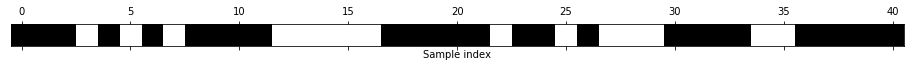

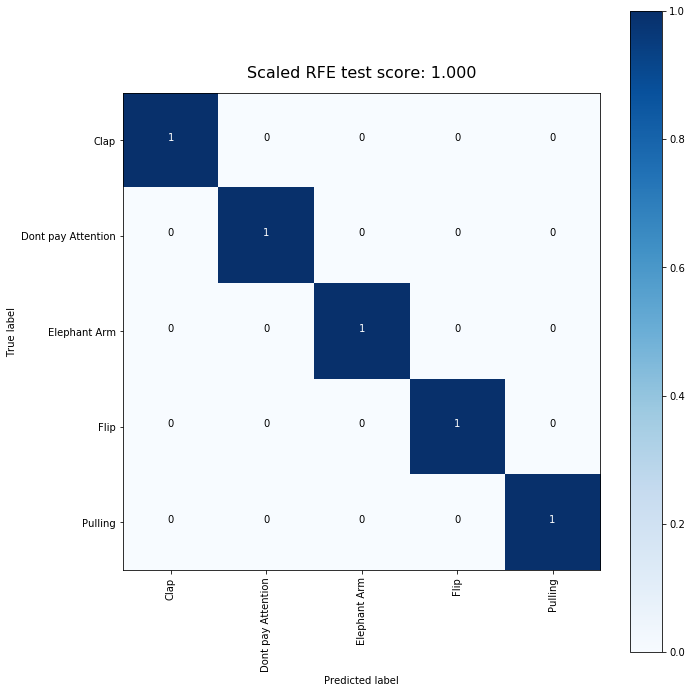

In [5]:
# Feature selection using Recursive Feature Elimination
# - See Section 4.7.3 of the Mueller book: 
#     https://learning.oreilly.com/library/view/introduction-to-machine/9781449369880/ch04.html
# - look a this pipeline article: https://ramhiser.com/post/2018-03-25-feature-selection-with-scikit-learn-pipeline/
# TODO: one issue is that we are learning parameters on the whole training set, this isn't so good

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE
from sklearn.preprocessing import StandardScaler

selected_gesture_set = get_gesture_set_with_str("Nicole")
(list_of_feature_vectors, feature_names) = extract_features_from_gesture_set(selected_gesture_set,
                                                                            include_dummy_data=True) 

df = pd.DataFrame(list_of_feature_vectors, columns = feature_names)
trial_indices = df.pop("trial_num")
X = df
y = df.pop('gesture')
gesturer = df.pop('gesturer')

# 80/20 split with stratification
# in this case, we have 5 gestures x 5 samples = 25 total
# so, 20% of this is 11 samples. we want to stratify by gesture name so that we get 1 example of each
# gesture in our test set. if we don't have stratify on, we could end up with an imbalanced test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, stratify=y) # random_state=42
print(y_test)
sorted_gesture_names = sorted(y_train.unique())

# Scale values
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)
clf = svm.SVC(kernel='linear')

# see: https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFE.html
num_features_to_eliminate = 15
selector = RFE(clf, n_features_to_select=len(X.columns) - num_features_to_eliminate)
selector.fit(X_train_scaled, y_train)

# visualize the selected features:
mask = selector.get_support()
print(mask)
print(selector.ranking_)
plt.matshow(mask.reshape(1, -1), cmap='gray_r')
plt.xlabel("Sample index")
plt.yticks(())

print(len(X.columns), X.columns)
print(len(X.columns[mask]), X.columns[mask])
print("eliminated vars", X.columns[~mask])

X_train_scaled_rfe = selector.transform(X_train_scaled)
X_test_scaled_rfe = selector.transform(X_test_scaled)

score = clf.fit(X_train, y_train).score(X_test, y_test)
print("Unscaled test score: {:.3f}".format(score))
score = clf.fit(X_train_scaled, y_train).score(X_test_scaled, y_test)
print("Scaled test score: {:.3f}".format(score))
score = clf.fit(X_train_scaled_rfe, y_train).score(X_test_scaled_rfe, y_test)
print("Scaled RFE test score: {:.3f}".format(score))

y_pred = clf.fit(X_train_scaled_rfe, y_train).predict(X_test_scaled_rfe)
cm = confusion_matrix(y_test, y_pred, labels=sorted_gesture_names)
print(cm)
plt.figure(figsize=(10,10))
plot_confusion_matrix(cm, classes=sorted_gesture_names, title="Scaled RFE test score: {:.3f}".format(score))
plt.show()

11          Elephant Arm
16                  Flip
4                   Clap
6     Dont pay Attention
24               Pulling
Name: gesture, dtype: object
[False  True  True  True  True  True  True  True  True  True False  True
 False False  True False False  True False  True  True  True  True  True
  True False False  True False  True  True  True False False False  True
 False  True False  True  True]
[16  1  1  1  1  1  1  1  1  1 15  1  3 14  1 10 12  1  9  1  1  1  1  1
  1 13  6  1  7  1  1  1 11  4  2  1  8  1  5  1  1]
41 Index(['length', 'mag_p.mean', 'x_p.mean', 'y_p.mean', 'z_p.mean', 'mag.mean',
       'x.mean', 'y.mean', 'z.mean', 'mag_p.median', 'x_p.median',
       'y_p.median', 'z_p.median', 'mag.median', 'x.median', 'y.median',
       'z.median', 'mag_p.var', 'x_p.var', 'y_p.var', 'z_p.var', 'mag.var',
       'x.var', 'y.var', 'z.var', 'mag_p.max', 'x_p.max', 'y_p.max', 'z_p.max',
       'mag.max', 'x.max', 'y.max', 'z.max', 'mag_p.min', 'x_p.min', 'y_p.min',
       'z_p

C:\Users\nicol\Anaconda3tryagain\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\nicol\Anaconda3tryagain\lib\site-packages\ipykernel_launcher.py:33: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
C:\Users\nicol\Anaconda3tryagain\lib\site-packages\ipykernel_launcher.py:34: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.


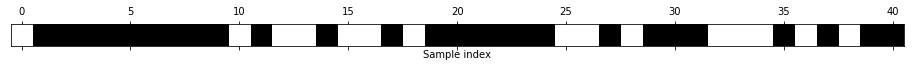

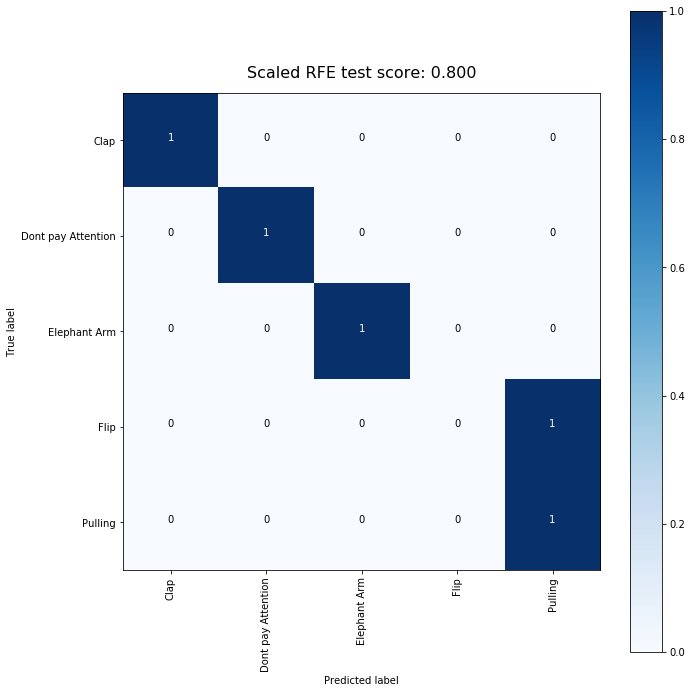

In [7]:
# Feature selection using Recursive Feature Elimination  (Rashmi)
# - See Section 4.7.3 of the Mueller book: 
#     https://learning.oreilly.com/library/view/introduction-to-machine/9781449369880/ch04.html
# - look a this pipeline article: https://ramhiser.com/post/2018-03-25-feature-selection-with-scikit-learn-pipeline/
# TODO: one issue is that we are learning parameters on the whole training set, this isn't so good

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE
from sklearn.preprocessing import StandardScaler

selected_gesture_set = get_gesture_set_with_str("Rashmi")
(list_of_feature_vectors, feature_names) = extract_features_from_gesture_set(selected_gesture_set,
                                                                            include_dummy_data=True) 

df = pd.DataFrame(list_of_feature_vectors, columns = feature_names)
trial_indices = df.pop("trial_num")
X = df
y = df.pop('gesture')
gesturer = df.pop('gesturer')

# 80/20 split with stratification
# in this case, we have 5 gestures x 5 samples = 25 total
# so, 20% of this is 11 samples. we want to stratify by gesture name so that we get 1 example of each
# gesture in our test set. if we don't have stratify on, we could end up with an imbalanced test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, stratify=y) # random_state=42
print(y_test)
sorted_gesture_names = sorted(y_train.unique())

# Scale values
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)
clf = svm.SVC(kernel='linear')

# see: https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFE.html
num_features_to_eliminate = 15
selector = RFE(clf, n_features_to_select=len(X.columns) - num_features_to_eliminate)
selector.fit(X_train_scaled, y_train)

# visualize the selected features:
mask = selector.get_support()
print(mask)
print(selector.ranking_)
plt.matshow(mask.reshape(1, -1), cmap='gray_r')
plt.xlabel("Sample index")
plt.yticks(())

print(len(X.columns), X.columns)
print(len(X.columns[mask]), X.columns[mask])
print("eliminated vars", X.columns[~mask])

X_train_scaled_rfe = selector.transform(X_train_scaled)
X_test_scaled_rfe = selector.transform(X_test_scaled)

score = clf.fit(X_train, y_train).score(X_test, y_test)
print("Unscaled test score: {:.3f}".format(score))
score = clf.fit(X_train_scaled, y_train).score(X_test_scaled, y_test)
print("Scaled test score: {:.3f}".format(score))
score = clf.fit(X_train_scaled_rfe, y_train).score(X_test_scaled_rfe, y_test)
print("Scaled RFE test score: {:.3f}".format(score))

y_pred = clf.fit(X_train_scaled_rfe, y_train).predict(X_test_scaled_rfe)
cm = confusion_matrix(y_test, y_pred, labels=sorted_gesture_names)
print(cm)
plt.figure(figsize=(10,10))
plot_confusion_matrix(cm, classes=sorted_gesture_names, title="Scaled RFE test score: {:.3f}".format(score))
plt.show()

48               Pulling
22          Elephant Arm
10    Dont pay Attention
0                   Clap
39                  Flip
Name: gesture, dtype: object
[ True False  True False False False False  True  True False  True False
  True False False False False False  True  True False  True False  True
 False False False  True False  True False  True False False False False
 False  True False False  True]
[ 1 27  1  5 16  6 18  1  1 19  1 22  1 24  9 21 20 14  1  1  7  1 25  1
 13 11  4  1 23  1 15  1  2  3  8 10 17  1 26 12  1]
41 Index(['length', 'mag_p.mean', 'x_p.mean', 'y_p.mean', 'z_p.mean', 'mag.mean',
       'x.mean', 'y.mean', 'z.mean', 'mag_p.median', 'x_p.median',
       'y_p.median', 'z_p.median', 'mag.median', 'x.median', 'y.median',
       'z.median', 'mag_p.var', 'x_p.var', 'y_p.var', 'z_p.var', 'mag.var',
       'x.var', 'y.var', 'z.var', 'mag_p.max', 'x_p.max', 'y_p.max', 'z_p.max',
       'mag.max', 'x.max', 'y.max', 'z.max', 'mag_p.min', 'x_p.min', 'y_p.min',
       'z_p

/Users/rashmi/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/rashmi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:33: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
/Users/rashmi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:34: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.


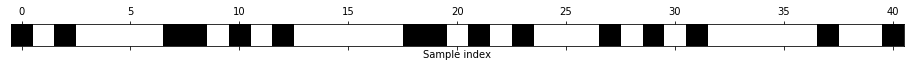

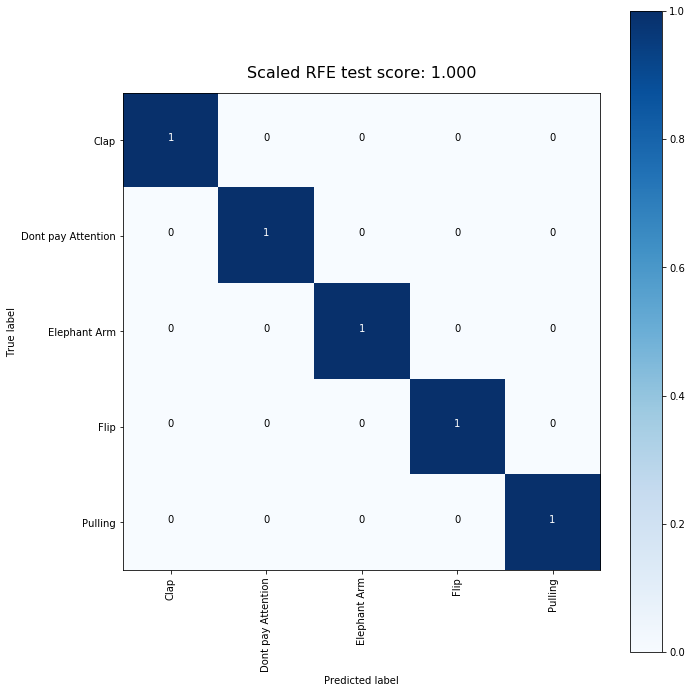

In [23]:
# Feature selection using Recursive Feature Elimination  (Combined)
# - See Section 4.7.3 of the Mueller book: 
#     https://learning.oreilly.com/library/view/introduction-to-machine/9781449369880/ch04.html
# - look a this pipeline article: https://ramhiser.com/post/2018-03-25-feature-selection-with-scikit-learn-pipeline/
# TODO: one issue is that we are learning parameters on the whole training set, this isn't so good

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE
from sklearn.preprocessing import StandardScaler

selected_gesture_set = get_gesture_set_with_str("Combined")
(list_of_feature_vectors, feature_names) = extract_features_from_gesture_set(selected_gesture_set,
                                                                            include_dummy_data=True) 

df = pd.DataFrame(list_of_feature_vectors, columns = feature_names)
trial_indices = df.pop("trial_num")
X = df
y = df.pop('gesture')
gesturer = df.pop('gesturer')

# 90/10 split with stratification
# in this case, we have 5 gestures x 10 samples = 50 total
# so, 10% of this is 5 samples. we want to stratify by gesture name so that we get 1 example of each
# gesture in our test set. if we don't have stratify on, we could end up with an imbalanced test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, stratify=y) # random_state=42
print(y_test)
sorted_gesture_names = sorted(y_train.unique())

# Scale values
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)
clf = svm.SVC(kernel='linear')

# see: https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFE.html
num_features_to_eliminate = 26
selector = RFE(clf, n_features_to_select=len(X.columns) - num_features_to_eliminate)
selector.fit(X_train_scaled, y_train)

# visualize the selected features:
mask = selector.get_support()
print(mask)
print(selector.ranking_)
plt.matshow(mask.reshape(1, -1), cmap='gray_r')
plt.xlabel("Sample index")
plt.yticks(())

print(len(X.columns), X.columns)
print(len(X.columns[mask]), X.columns[mask])
print("eliminated vars", X.columns[~mask])

X_train_scaled_rfe = selector.transform(X_train_scaled)
X_test_scaled_rfe = selector.transform(X_test_scaled)

score = clf.fit(X_train, y_train).score(X_test, y_test)
print("Unscaled test score: {:.3f}".format(score))
score = clf.fit(X_train_scaled, y_train).score(X_test_scaled, y_test)
print("Scaled test score: {:.3f}".format(score))
score = clf.fit(X_train_scaled_rfe, y_train).score(X_test_scaled_rfe, y_test)
print("Scaled RFE test score: {:.3f}".format(score))

y_pred = clf.fit(X_train_scaled_rfe, y_train).predict(X_test_scaled_rfe)
cm = confusion_matrix(y_test, y_pred, labels=sorted_gesture_names)
print(cm)
plt.figure(figsize=(10,10))
plot_confusion_matrix(cm, classes=sorted_gesture_names, title="Scaled RFE test score: {:.3f}".format(score))
plt.show()

49               Pulling
45               Pulling
20          Elephant Arm
39                  Flip
12    Dont pay Attention
27          Elephant Arm
2                   Clap
0                   Clap
36                  Flip
18    Dont pay Attention
Name: gesture, dtype: object
[ True False  True  True False  True False  True False False  True False
 False False False False False False  True  True False  True False  True
 False False False  True False False False  True False  True False False
 False  True False False  True]
[ 1 23  1  1 18  1 15  1  3 17  1 22 13 25  7 21 20 16  1  1  4  1 27  1
  6  8 14  1 19  2 12  1  5  1  9 11 24  1 26 10  1]
41 Index(['length', 'mag_p.mean', 'x_p.mean', 'y_p.mean', 'z_p.mean', 'mag.mean',
       'x.mean', 'y.mean', 'z.mean', 'mag_p.median', 'x_p.median',
       'y_p.median', 'z_p.median', 'mag.median', 'x.median', 'y.median',
       'z.median', 'mag_p.var', 'x_p.var', 'y_p.var', 'z_p.var', 'mag.var',
       'x.var', 'y.var', 'z.var', 'mag_p.max',

C:\Users\nicol\Anaconda3tryagain\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\nicol\Anaconda3tryagain\lib\site-packages\ipykernel_launcher.py:33: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
C:\Users\nicol\Anaconda3tryagain\lib\site-packages\ipykernel_launcher.py:34: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.


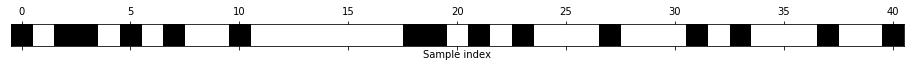

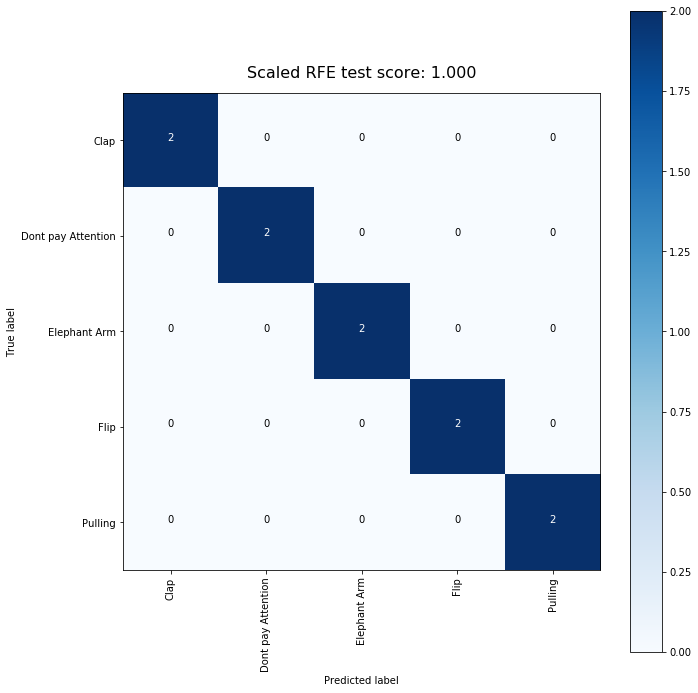

In [8]:
# Feature selection using Recursive Feature Elimination  (Combined with 0.2 test size)
# - See Section 4.7.3 of the Mueller book: 
#     https://learning.oreilly.com/library/view/introduction-to-machine/9781449369880/ch04.html
# - look a this pipeline article: https://ramhiser.com/post/2018-03-25-feature-selection-with-scikit-learn-pipeline/
# TODO: one issue is that we are learning parameters on the whole training set, this isn't so good

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE
from sklearn.preprocessing import StandardScaler

selected_gesture_set = get_gesture_set_with_str("Combined")
(list_of_feature_vectors, feature_names) = extract_features_from_gesture_set(selected_gesture_set,
                                                                            include_dummy_data=True) 

df = pd.DataFrame(list_of_feature_vectors, columns = feature_names)
trial_indices = df.pop("trial_num")
X = df
y = df.pop('gesture')
gesturer = df.pop('gesturer')

# 80/20 split with stratification
# in this case, we have 5 gestures x 10 samples = 50 total
# so, 10% of this is 10 samples. we want to stratify by gesture name so that we get 1 example of each
# gesture in our test set. if we don't have stratify on, we could end up with an imbalanced test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, stratify=y) # random_state=42
print(y_test)
sorted_gesture_names = sorted(y_train.unique())

# Scale values
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)
clf = svm.SVC(kernel='linear')

# see: https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFE.html
num_features_to_eliminate = 26
selector = RFE(clf, n_features_to_select=len(X.columns) - num_features_to_eliminate)
selector.fit(X_train_scaled, y_train)

# visualize the selected features:
mask = selector.get_support()
print(mask)
print(selector.ranking_)
plt.matshow(mask.reshape(1, -1), cmap='gray_r')
plt.xlabel("Sample index")
plt.yticks(())

print(len(X.columns), X.columns)
print(len(X.columns[mask]), X.columns[mask])
print("eliminated vars", X.columns[~mask])

X_train_scaled_rfe = selector.transform(X_train_scaled)
X_test_scaled_rfe = selector.transform(X_test_scaled)

score = clf.fit(X_train, y_train).score(X_test, y_test)
print("Unscaled test score: {:.3f}".format(score))
score = clf.fit(X_train_scaled, y_train).score(X_test_scaled, y_test)
print("Scaled test score: {:.3f}".format(score))
score = clf.fit(X_train_scaled_rfe, y_train).score(X_test_scaled_rfe, y_test)
print("Scaled RFE test score: {:.3f}".format(score))

y_pred = clf.fit(X_train_scaled_rfe, y_train).predict(X_test_scaled_rfe)
cm = confusion_matrix(y_test, y_pred, labels=sorted_gesture_names)
print(cm)
plt.figure(figsize=(10,10))
plot_confusion_matrix(cm, classes=sorted_gesture_names, title="Scaled RFE test score: {:.3f}".format(score))
plt.show()

'Combined' : 5 gestures and 50 total trials
[['Combined', 'Clap', 0, 830, 0.0023985495025693904, -0.11081349705872286, 0.13322749662042294, -0.027040941818284474, 962.909589244582, 558.0602409638554, 528.3975903614457, 571.6301204819277, -5.985224893223421, 0.9028099682787798, -11.852867516890184, 0.7511360295754452, 945.5987514505861, 559.0, 524.0, 589.0, 1825.6368658849083, 1143.2801017215118, 1943.277207562051, 3533.8926638595663, 3857.928964926754, 2034.2035999419363, 5862.2732472056905, 5760.0884903469305, 135.574680427496, 78.98666745822125, 134.4966977637811, 189.22999083031334, 1430.5750591982232, 910.0, 903.0, 790.0, -110.37660985579217, -102.25488510503853, -85.03049692859831, -151.9099325854629, 607.7589982879726, 411.0, 240.0, 131.0], ['Combined', 'Clap', 1, 941, -0.01477091581675053, -0.1224806841265122, 0.07442249078020385, 0.00818427313843073, 906.1288444942389, 542.1689691817215, 499.06907545164717, 517.13390010627, -8.781106867492406, -4.078960354937783, -7.26836874007

C:\Users\nicol\Anaconda3tryagain\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\nicol\Anaconda3tryagain\lib\site-packages\ipykernel_launcher.py:31: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
C:\Users\nicol\Anaconda3tryagain\lib\site-packages\ipykernel_launcher.py:32: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.


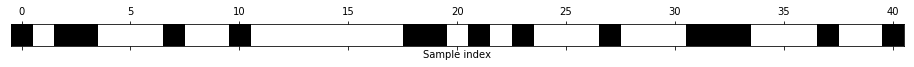

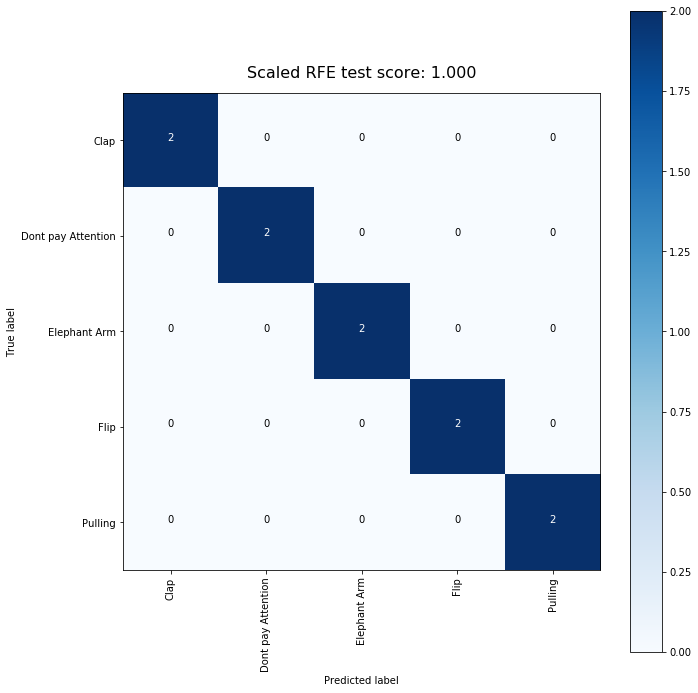

In [11]:
#trying to predict the label and then do the distance between the label and the average gesture in a set
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE
from sklearn.preprocessing import StandardScaler

selected_gesture_set = get_gesture_set_with_str("Combined")
print(selected_gesture_set)
(list_of_feature_vectors, feature_names) = extract_features_from_gesture_set(selected_gesture_set,
                                                                            include_dummy_data=True) 
print(list_of_feature_vectors)
print(feature_names)

df = pd.DataFrame(list_of_feature_vectors, columns = feature_names)
trial_indices = df.pop("trial_num")
X = df
y = df.pop('gesture')
gesturer = df.pop('gesturer')

# 80/20 split with stratification
# in this case, we have 5 gestures x 10 samples = 50 total
# so, 10% of this is 10 samples. we want to stratify by gesture name so that we get 1 example of each
# gesture in our test set. if we don't have stratify on, we could end up with an imbalanced test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, stratify=y) # random_state=42
print(y_test)
sorted_gesture_names = sorted(y_train.unique())

# Scale values
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)
clf = svm.SVC(kernel='linear')

# see: https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFE.html
num_features_to_eliminate = 26
selector = RFE(clf, n_features_to_select=len(X.columns) - num_features_to_eliminate)
selector.fit(X_train_scaled, y_train)

# visualize the selected features:
mask = selector.get_support()
print(mask)
print(selector.ranking_)
plt.matshow(mask.reshape(1, -1), cmap='gray_r')
plt.xlabel("Sample index")
plt.yticks(())

print(len(X.columns), X.columns)
print(len(X.columns[mask]), X.columns[mask])
print("eliminated vars", X.columns[~mask])

X_train_scaled_rfe = selector.transform(X_train_scaled)
X_test_scaled_rfe = selector.transform(X_test_scaled)

score = clf.fit(X_train, y_train).score(X_test, y_test)
print("Unscaled test score: {:.3f}".format(score))
score = clf.fit(X_train_scaled, y_train).score(X_test_scaled, y_test)
print("Scaled test score: {:.3f}".format(score))
score = clf.fit(X_train_scaled_rfe, y_train).score(X_test_scaled_rfe, y_test)
print("Scaled RFE test score: {:.3f}".format(score))

y_pred = clf.fit(X_train_scaled_rfe, y_train).predict(X_test_scaled_rfe)
#for label in y_pred:
    
cm = confusion_matrix(y_test, y_pred, labels=sorted_gesture_names)
print(cm)
plt.figure(figsize=(10,10))
plot_confusion_matrix(cm, classes=sorted_gesture_names, title="Scaled RFE test score: {:.3f}".format(score))
plt.show()

y_pred = clf.fit(X_train_scaled_rfe, y_train).predict(X_test_scaled_rfe)